In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import pickle

# ColumnTransformer и Pipeline

In [ ]:
# Пример данных (замените на ваши данные)
data = {
    'feature_num1': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'feature_num2': [10, 20, 30, 40, 50, 10, 20, 30, 40, 50],
    'feature_cat': ['A', 'B', 'A', 'C', 'B', 'A', 'B', 'A', 'C', 'B'],
    'target': [0, 1, 0, 1, 0, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)
X = df.drop('target', axis=1)
y = df['target']

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение числовых и категориальных признаков
numerical_features = ['feature_num1', 'feature_num2']
categorical_features = ['feature_cat']
# Создание преобразователей
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Объединение преобразователей
preprocessor = ColumnTransformer(
    transformers = [
        ('num', 'passthrough', numerical_features),  # 'passthrough' для числовых
        ('cat', categorical_transformer, categorical_features)
    ])

# Полный pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), # Scaler применяется после объединения
    ('pca', PCA(n_components=2)),
    ('classifier', CatBoostClassifier(iterations=100, verbose=0, random_seed=42))
])

# Обучение и сохранение -  как в предыдущем примере
pipeline.fit(X_train, y_train)
with open('trained_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Загрузка и использование - как в предыдущем примере
with open('trained_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

y_pred = loaded_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (loaded pipeline): {accuracy}")

new_data = pd.DataFrame({'feature_num1': [6], 'feature_num2': [60], 'feature_cat': ['C']})
new_prediction = loaded_pipeline.predict(new_data)
print(f"Prediction for new data (loaded pipeline): {new_prediction}")

Теперь используется  'passthrough' в ColumnTransformer для числовых признаков.  Это означает, что числовые признаки просто пропускаются через преобразователь без изменений.  После этого StandardScaler применяется ко всему результату преобразования ColumnTransformer (числовые + OHE категориальные).

• OneHotEncoder: Он сохранит порядок категорий, которые он встретил в обучающей выборке. Это критически важно, потому что при применении к новым данным он будет использовать тот же порядок категорий, что и при обучении. Неизвестные категории будут обработаны в соответствии с параметром handle_unknown (обычно 'ignore' или 'error').

• StandardScaler: Он сохранит вычисленные средние значения и стандартные отклонения для каждого признака (как числовых, так и категориальных после OHE). Новые данные будут центрированы и масштабированы с использованием этих же средних и стандартных отклонений.

• PCA: Он сохранит обученные компоненты PCA (собственные векторы и значения). Новые данные будут спроецированы на эти же компоненты.

• CatBoostClassifier (или Regressor): Модель CatBoost также сохранит свои внутренние параметры и обученные веса.

Поэтому, когда вы применяете сохранённый pipeline к новым данным, он выполняет те же самые преобразования, что и на обучающей выборке, используя те же самые параметры, гарантируя согласованность предсказаний. Это ключевое преимущество использования pipeline для машинного обучения – воспроизводимость и простота применения к новым данным.

Вы подаёте на вход pipeline одну таблицу (DataFrame в Pandas), содержащую как числовые, так и категориальные столбцы. ColumnTransformer внутри pipeline сам позаботится о разделении данных на числовые и категориальные части, применении OneHotEncoder к категориальным, объединении результатов, StandardScaler и PCA.

Критически важно, чтобы:

1. Названия столбцов (факторов) в новых данных точно соответствовали названиям столбцов в обучающей выборке. OneHotEncoder и StandardScaler работают с конкретными столбцами, и если названия столбцов не совпадут, то произойдёт ошибка или неверная обработка данных.

2. Порядок столбцов может быть не важен (но лучше одинаковый), так как ColumnTransformer явно указывает, к каким столбцам применять какие преобразования. Тем не менее, для лучшей читаемости и предотвращения потенциальных ошибок лучше, чтобы порядок столбцов в новых данных совпадал с порядком в обучающей выборке.

3. Типы данных столбцов в новых данных должны соответствовать типам данных в обучающей выборке. Например, если в обучающей выборке категориальный столбец был строкового типа, то в новых данных он тоже должен быть строкового типа.

Если все эти условия выполнены, то вы можете подать DataFrame на вход pipeline, и он корректно выполнит все этапы предобработки и сделает предсказание. Если возникнут ошибки, проверьте соответствие названий и типов столбцов. Если в новых данных есть категориальные значения, которых не было в обучающих данных, то поведение будет зависеть от параметра handle_unknown в OneHotEncoder. По умолчанию, если handle_unknown='ignore', то новые категории будут проигнорированы (им будут соответствовать нулевые значения во всех новых фичах). Если handle_unknown='error', то вы получите ошибку.

# Использование FunctionTransformer

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from catboost import CatBoostClassifier
import pickle

In [ ]:
# ... (данные и разделение на train/test, как в предыдущих примерах) ...

# ... (определение числовых и категориальных признаков, как в предыдущих примерах) ...

# Пример пользовательской функции (замените на ваши функции)
def my_custom_transformation(df):
    # Пример: добавление нового признака - квадрат первого числового признака
    df['feature_num1_squared'] = df['feature_num1'] ** 2
    return df

def another_custom_transformation(df):
    #Пример: удаление выбросов
    df = df[df['feature_num2'] < 55]
    return df

# Создание преобразователей
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение преобразователей
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Полный pipeline с пользовательскими функциями
pipeline = Pipeline(steps=[
    ('custom_transform1', FunctionTransformer(my_custom_transformation)),
    ('custom_transform2', FunctionTransformer(another_custom_transformation)),
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', CatBoostClassifier(iterations=100, verbose=0, random_seed=42))
])

# Обучение и сохранение (как в предыдущих примерах)
pipeline.fit(X_train, y_train)
with open('trained_pipeline_with_custom_functions.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Загрузка и использование (как в предыдущих примерах)
with open('trained_pipeline_with_custom_functions.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

y_pred = loaded_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (loaded pipeline): {accuracy}")

new_data = pd.DataFrame({'feature_num1': [6], 'feature_num2': [60], 'feature_cat': ['C']})
new_prediction = loaded_pipeline.predict(new_data)
print(f"Prediction for new data (loaded pipeline): {new_prediction}")

# Отдельный pipeline для предобработки

In [ ]:
# ... (данные и разделение на train/test, как в предыдущих примерах) ...

# ... (определение числовых и категориальных признаков, как в предыдущих примерах) ...

# Пример пользовательской функции (замените на ваши функции)
def my_custom_transformation(df):
    # Пример: добавление нового признака - квадрат первого числового признака
    df['feature_num1_squared'] = df['feature_num1'] ** 2
    return df

def another_custom_transformation(df):
    #Пример: удаление выбросов
    df = df[df['feature_num2'] < 55]
    return df

custom_preprocessing_pipeline = Pipeline([
    ('custom_transform1', FunctionTransformer(my_custom_transformation)),
    ('custom_transform2', FunctionTransformer(another_custom_transformation)),
])

main_pipeline = Pipeline([
    ('custom_preprocessor', custom_preprocessing_pipeline),
    ('preprocessor', preprocessor), # preprocessor from the previous examples
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', CatBoostClassifier(iterations=100, verbose=0, random_seed=42))
])

# Обучение, сохранение и загрузка как в предыдущих примерах

# XGBoost:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# 1. Генерация данных (пример данных с категориальными и числовыми признаками)
data = pd.DataFrame({
    "square_meters": [50, 75, 100, 120, 60],
    "floor": [1, 5, 10, 15, 3],
    "district": ["A", "B", "A", "C", "B"],
    "condition": ["good", "poor", "excellent", "good", "excellent"],
    "price": [3_000_000, 5_500_000, 7_200_000, 10_000_000, 4_000_000]
})

# 2. Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop(columns="price")
y = data["price"]

# 3. Определяем, какие признаки категориальные, а какие числовые
categorical_features = ["district", "condition"]
numerical_features = ["square_meters", "floor"]

# 4. Создание препроцессора (OHE для категориальных и "передача как есть" для числовых)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),  # Числовые передаем как есть
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)  # OHE для категориальных
    ]
)

# 5. Создаем модель XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# 6. Объединяем предобработку и модель в единый пайплайн
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb_model)
])

# 7. Разделяем данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Обучаем модель
pipeline.fit(X_train, y_train)

# 9. Делаем предсказания на тестовых данных
y_pred = pipeline.predict(X_test)

# 10. Пример предсказания для нового объекта
new_data = pd.DataFrame({
    "square_meters": [80],
    "floor": [7],
    "district": ["B"],
    "condition": ["good"]
})
predicted_price = pipeline.predict(new_data)

print("Предсказанная цена:", predicted_price[0])


<Figure size 1000x600 with 0 Axes>

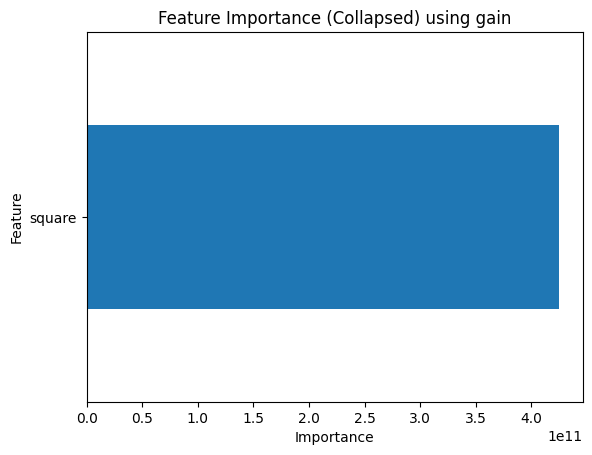

In [13]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# 1. Генерация данных
data = pd.DataFrame({
    "square_meters": [50, 75, 100, 120, 60],
    "floor": [1, 5, 10, 15, 3],
    "condition": ["cosmetic", "euro", "premium", "cosmetic", "euro"],  # Категориальный признак
    "price": [3_000_000, 5_500_000, 7_200_000, 10_000_000, 4_000_000]
})

# 2. Разделение на признаки и целевую переменную
X = data.drop(columns="price")
y = data["price"]

# 3. Определяем категориальные и числовые признаки
categorical_features = ["condition"]
numerical_features = ["square_meters", "floor"]

# 4. Создание ColumnTransformer для OHE
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),  # Числовые передаем как есть
        ("cat", OneHotEncoder(), categorical_features)  # OHE для категориальных
    ]
)

# 5. Преобразование данных
X_transformed = preprocessor.fit_transform(X)

# 6. Получение новых имен признаков после OHE
ohe_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(ohe_feature_names)

# 7. Обучение модели XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model.fit(X_transformed, y)

# 8. Получение важности признаков
importance_type = "gain"  # Выбираем тип важности: "weight", "gain", "cover"
raw_importances = xgb_model.get_booster().get_score(importance_type=importance_type)

# 9. Преобразование важностей в DataFrame
# Связываем названия признаков с важностями
mapped_importances = {feature_names[int(key[1:])]: value for key, value in raw_importances.items()}

# 10. Схлопывание важностей для категориальных признаков
collapsed_importance = {}
for feature, importance in mapped_importances.items():
    base_feature = feature.split("_")[0]  # Получаем исходное имя признака
    if base_feature in collapsed_importance:
        collapsed_importance[base_feature] += importance
    else:
        collapsed_importance[base_feature] = importance

# 11. Преобразование в DataFrame для визуализации
collapsed_importance_df = pd.DataFrame(list(collapsed_importance.items()), columns=["feature", "importance"])

# 12. Визуализация схлопнутой важности
plt.figure(figsize=(10, 6))
collapsed_importance_df.sort_values(by="importance", ascending=False).plot.barh(x="feature", y="importance", legend=False)
plt.title(f"Feature Importance (Collapsed) using {importance_type}")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [19]:
feature_names

['square_meters',
 'floor',
 'condition_cosmetic',
 'condition_euro',
 'condition_premium']

Размер преобразованной матрицы: (5, 5)
Названия признаков после OHE: ['floor', 'square_meters', 'condition_cosmetic', 'condition_euro', 'condition_premium']
Важности признаков до схлопывания:
floor: 370.0


<Figure size 1000x600 with 0 Axes>

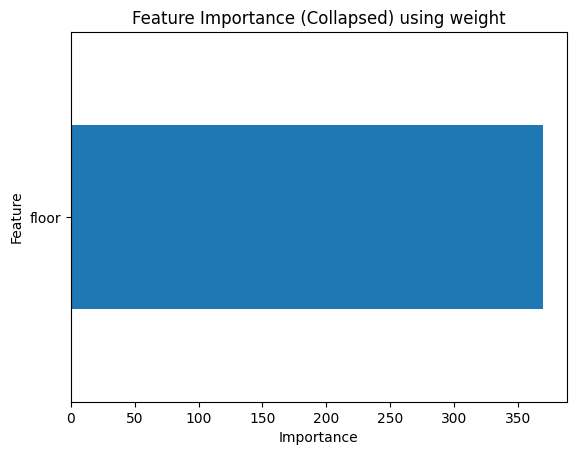

In [28]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

# 1. Создаем искусственный набор данных
data = pd.DataFrame({
    "floor": [1, 5, 10, 15, 3],
    "square_meters": [50, 75, 100, 120, 60],
    "condition": ["cosmetic", "euro", "premium", "cosmetic", "euro"],  # Категориальный признак
    "price": [3_000_000, 5_500_000, 7_200_000, 10_000_000, 4_000_000]
})

# 2. Разделение на признаки и целевую переменную
X = data.drop(columns="price")
y = data["price"]

# 3. Определяем категориальные и числовые признаки
categorical_features = ["condition"]
numerical_features = ["floor", "square_meters"]

# 4. Создание ColumnTransformer для OHE
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),  # Числовые признаки передаем как есть
        ("cat", OneHotEncoder(sparse_output=False), categorical_features)  # OHE для категориальных
    ]
)

# 5. Преобразование данных
X_transformed = preprocessor.fit_transform(X)

# Получение новых имен признаков после OHE
ohe_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(ohe_feature_names)

# Проверяем размерность
print("Размер преобразованной матрицы:", X_transformed.shape)
print("Названия признаков после OHE:", feature_names)

# 6. Обучение модели XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_transformed, y)

# 7. Получение важности признаков
importance_type = "weight"  # Тип важности: weight, gain, cover
raw_importances = xgb_model.get_booster().get_score(importance_type=importance_type)

# Связываем названия признаков с важностями
mapped_importances = {feature_names[int(key[1:])]: value for key, value in raw_importances.items()}

# Вывод важностей для проверки
print("Важности признаков до схлопывания:")
for feature, importance in mapped_importances.items():
    print(f"{feature}: {importance}")

# 8. Схлопывание важностей для категориальных признаков
collapsed_importance = {}
for feature, importance in mapped_importances.items():
    base_feature = feature.split("_")[0]  # Получаем исходное имя признака
    if base_feature in collapsed_importance:
        collapsed_importance[base_feature] += importance
    else:
        collapsed_importance[base_feature] = importance

# Преобразование в DataFrame для визуализации
collapsed_importance_df = pd.DataFrame(list(collapsed_importance.items()), columns=["feature", "importance"])

# 9. Визуализация схлопнутой важности
plt.figure(figsize=(10, 6))
collapsed_importance_df.sort_values(by="importance", ascending=False).plot.barh(x="feature", y="importance", legend=False)
plt.title(f"Feature Importance (Collapsed) using {importance_type}")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [30]:
X_transformed

array([[  1.,  50.,   1.,   0.,   0.],
       [  5.,  75.,   0.,   1.,   0.],
       [ 10., 100.,   0.,   0.,   1.],
       [ 15., 120.,   1.,   0.,   0.],
       [  3.,  60.,   0.,   1.,   0.]])

Форма X_transformed: (5, 5)
Пример преобразованных данных:
   square_meters  floor  condition_cosmetic  condition_euro  condition_premium
0           50.0    1.0                 1.0             0.0                0.0
1           75.0    5.0                 0.0             1.0                0.0
2          100.0   10.0                 0.0             0.0                1.0
3          120.0   15.0                 1.0             0.0                0.0
4           60.0    3.0                 0.0             1.0                0.0
Важности признаков из XGBoost:
{'f0': 425019899904.0}
Схлопнутая важность:
{'square': 425019899904.0}


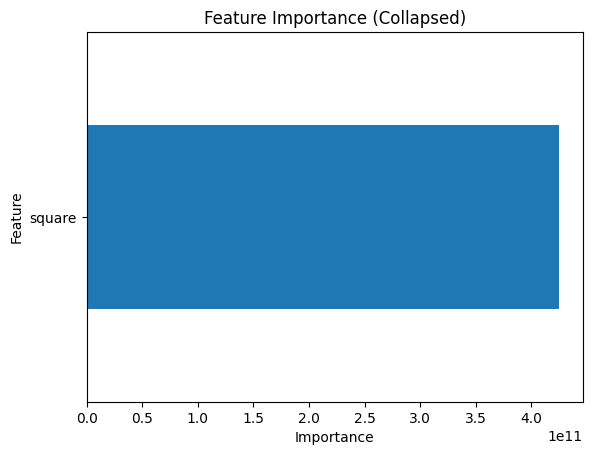

In [24]:
# Проверяем форму данных после преобразования
print("Форма X_transformed:", X_transformed.shape)
print("Пример преобразованных данных:")
print(pd.DataFrame(X_transformed, columns=feature_names).head())

# Убедимся, что все признаки подаются модели
xgb_model.fit(X_transformed, y)

# Проверка важностей признаков
raw_importances = xgb_model.get_booster().get_score(importance_type="gain")

# Выводим все, что видит XGBoost
print("Важности признаков из XGBoost:")
print(raw_importances)

# Если важности признаков всё ещё пусты или возвращается только один признак:
if not raw_importances:
    print("XGBoost не видит все признаки. Проверьте формат входных данных.")

# Если всё работает корректно, продолжаем с объединением категориальных признаков
mapped_importances = {feature_names[int(key[1:])]: value for key, value in raw_importances.items()}

# Схлопываем категории
collapsed_importance = {}
for feature, importance in mapped_importances.items():
    base_feature = feature.split("_")[0]
    collapsed_importance[base_feature] = collapsed_importance.get(base_feature, 0) + importance

# Вывод для отладки
print("Схлопнутая важность:")
print(collapsed_importance)

# Визуализация
collapsed_importance_df = pd.DataFrame(list(collapsed_importance.items()), columns=["feature", "importance"])
collapsed_importance_df.sort_values(by="importance", ascending=False).plot.barh(x="feature", y="importance", legend=False)
plt.title("Feature Importance (Collapsed)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()